# Training Classifier Vidmizer

<li>https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html</li>

# Classifier 2D Binaire vidmizer sur un Resnet
<p> Le code utilisé est celui de notre précédent classifier qui a été modifié </p>

## Loader

### Gestion de l'accès au drive / import des bibliothèques / Gestion de l'accès au GPU

In [2]:
########## Accès au drive ########
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
########## Positionnement dans le repertoire ########
# %cd /content/drive/MyDrive/TSP/HTI/PFE
#%cd /content/drive/MyDrive/PFE
# !ls /content/drive/MyDrive/TSP/HTI/PFE
!ls /content

drive  Loader_2D_C_ycbcr.py  sample_data


In [4]:
# !unzip /content/drive/MyDrive/TSP/HTI/PFE/train_vidmizer.zip
# !unzip /content/drive/MyDrive/TSP/HTI/PFE/test_vidmizer.zip
# !unzip /content/train_vidmizer.zip
# !unzip /content/test_vidmizer.zip

!unzip /content/drive/MyDrive/TSP/HTI/PFE/test_vidmizer.zip -d /content/
!unzip /content/drive/MyDrive/TSP/HTI/PFE/train_vidmizer.zip -d /content/

Archive:  /content/drive/MyDrive/TSP/HTI/PFE/test_vidmizer.zip
   creating: /content/test_vidmizer/
  inflating: /content/test_vidmizer/tiktok_179_ycbcr_6.npy  
  inflating: /content/test_vidmizer/vidmizer_173_ycbcr_5.npy  
  inflating: /content/test_vidmizer/youtube_174_ycbcr_2.npy  
  inflating: /content/test_vidmizer/youtube_168_ycbcr_3.npy  
  inflating: /content/test_vidmizer/vidmizer_199_ycbcr_17.npy  
  inflating: /content/test_vidmizer/vidmizer_195_ycbcr_8.npy  
  inflating: /content/test_vidmizer/vidmizer_189_ycbcr_9.npy  
  inflating: /content/test_vidmizer/vidmizer_174_ycbcr_9.npy  
  inflating: /content/test_vidmizer/vidmizer_168_ycbcr_8.npy  
  inflating: /content/test_vidmizer/tiktok_198_ycbcr_7.npy  
  inflating: /content/test_vidmizer/youtube_195_ycbcr_3.npy  
  inflating: /content/test_vidmizer/youtube_189_ycbcr_2.npy  
  inflating: /content/test_vidmizer/youtube_180_ycbcr_1.npy  
  inflating: /content/test_vidmizer/youtube_163_ycbcr_85.npy  
  inflating: /content/test

In [5]:
###### Librairies #######
import os
import pandas as pd
import glob
from torchvision.io import read_image
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
#########################

In [7]:
!ls /content/

drive  Loader_2D_C_ycbcr.py  sample_data  test_vidmizer  train_vidmizer


In [8]:
########## Gestion du GPU ###########
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # see if gpu is available
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


### Fonctions de Customisation de Dataset et de Loader

In [9]:
########### Importation de la Classe Customisée ######
import sys
# !cd /content/drive/MyDrive/TSP/HTI/PFE
sys.path.append('Loader_2D_C_ycbcr.py')
print(sys.path)
from Loader_2D_C_ycbcr import CustomImageDataset

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', 'Loader_2D_C_ycbcr.py']


In [10]:
################# Modification selon la classe  du RESNET #########@

########## Path ##########
dataset_2D = './train_vidmizer'
dataset_test_2D = './test_vidmizer'
annotation_test = dataset_test_2D + '/label_test_vidmizer.txt'
annotation = dataset_2D + '/label_train_vidmizer.txt'

Calcul de la mean et de la vairiance du dataset

In [11]:
# # Initialiser des variables pour accumuler les sommes et les sommes des carrés
# sum_of_pixels = 0
# sum_of_squares = 0
# num_of_pixels = 0

# # Parcourir le répertoire et charger chaque fichier .npy
# for filename in os.listdir(dataset_2D):
#     if filename.endswith('.npy'):
#         filepath = os.path.join(dataset_2D, filename)
#         data = np.load(filepath)  # Charger le fichier .npy

#         # Accumuler les valeurs
#         sum_of_pixels += np.sum(data)
#         sum_of_squares += np.sum(data ** 2)
#         num_of_pixels += data.size
#         print(filepath)

# # Calcul de la moyenne et de l'écart-type
# mean = sum_of_pixels / num_of_pixels
# std = np.sqrt((sum_of_squares / num_of_pixels) - (mean ** 2))
# print()
# print(f'Mean: {mean:.3f}, Std: {std:.3f}')
mean = -0.159
std = 16.460

In [12]:
##### Image preprocessing #####
from torchvision import transforms
preprocess = transforms.Compose([
        # transforms.ToTensor(),
        transforms.Resize(576, antialias=True),  # image batch, resize smaller edge to 576
        transforms.CenterCrop(576),  # image batch, center crop to square 576x576
        # transforms.Normalize(mean=[mean, mean, mean], std=[std, std, std])
])

### Instance des Datasets et Loaders

In [13]:
############## Paramètre ################
batch_size = 64

############## Train Part ###############
train_set = CustomImageDataset(
    annotations_file = annotation,
    npy_dir = dataset_2D,
    transform=preprocess
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

############## Test Part ################

test_set = CustomImageDataset(
    annotations_file = annotation_test,
    npy_dir = dataset_test_2D,
    transform=preprocess
)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)



In [14]:
# sample_1 = train_set[0][0]
# print(sample_1.shape)
# print()
# print(train_set[1])
# print("max value : ", torch.max(sample_1), "min value : ", torch.min(sample_1))

### Try loader

torch.Size([3, 576, 576])


<function matplotlib.pyplot.show(close=None, block=None)>

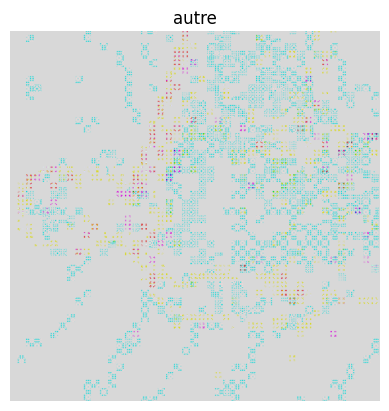

In [15]:
###### Fonction d'affichage ######
def denormalize(img_tensor):
        inverse_normalize = transforms.Normalize(
            mean=[-mean/std, -mean/std, -mean/std],
            std=[1/std, 1/std, 1/std]
        )
        return (inverse_normalize(img_tensor) * 255.).type(torch.uint8).permute(1, 2, 0).numpy()

labels_map = {
    0: "vidmizer" ,
    1: "autre",
}

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

img = images[0]
label = labels[0]
print(img.size())

plt.title(labels_map[int(label.numpy())])
plt.axis("off")
plt.imshow(denormalize(img))
plt.show


## Classifier

### Define the Convolutional Neural Network ( Utilisation de ResNet )

In [16]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm



In [17]:
net = torchvision.models.resnet18(weights=None)
num_ftrs = net.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
net.fc = nn.Linear(num_ftrs, 2)

In [18]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Define a Loss function and optimizer

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=.1)

In [20]:
num_class = 2

def quality_measurement(confusion_matrix):
    line_sum=torch.sum(confusion_matrix,dim=1)
    column_sum = torch.sum(confusion_matrix, dim=0)
    total_sum=torch.sum(confusion_matrix)
    Accuracy=torch.sum(torch.diag(confusion_matrix))/total_sum
    Precision=torch.diag(confusion_matrix)/line_sum
    Recall=torch.diag(confusion_matrix)/column_sum
    F1_score = 2 * (Precision * Recall)/(Precision+Recall)
    Pfa=(line_sum - torch.diag(confusion_matrix))/total_sum
    Pmd=(column_sum - torch.diag(confusion_matrix))/total_sum
    print("Accuracy : {}".format(Accuracy.item()))
    print("Precision 0 : {} - Precision 1 : {}".format(Precision[0],Precision[1]))
    print("Recall 0 : {} - Recall 1 : {}".format(Recall[0], Recall[1]))
    print("F1 score 0 : {} - F1 score 1 : {}".format(F1_score[0], F1_score[1]))
    print("Pfa 0 : {} - Pfa 1 : {}".format(Pfa[0], Pfa[1]))
    print("Pmd 0 : {} - Pmd 1 : {}".format(Pmd[0], Pmd[1]))
    return torch.nanmean(Accuracy),torch.nanmean(Precision),torch.nanmean(Recall),torch.nanmean(Recall),torch.nanmean(Pfa),torch.nanmean(Pmd)

def test_accuracy():
  net.eval()
  correct = 0
  total = 0
  confusion_matrix=torch.zeros((num_class,num_class),device=device)
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in test_loader:
          images, labels = data

          images = images.to(device)
          labels = labels.to(device)

          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          for i in range(len(labels)):
                label=int(labels[i])
                confusion_matrix[predicted[i],label]=confusion_matrix[predicted[i],label]+1
  net.train()
  print(quality_measurement(confusion_matrix))
  return  correct / total, confusion_matrix

In [21]:
list_lr = [0.1]#, 0.01, 0.001, 0.0001]
loss_saveds=[]
accuracy_saveds=[]
test_accuracy_saveds=[]



for lr_v in list_lr :
  net = torchvision.models.resnet18(weights=None)
  num_ftrs = net.fc.in_features
  net.fc = nn.Linear(num_ftrs, 2)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr_v)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=.1)
  net = net.to(device)
  loss_saved=[]
  accuracy_saved=[]
  test_accuracy_saved=[]


  for epoch in tqdm(range(23)):  # loop over the dataset multiple times

      running_loss = 0.0
      correct = 0
      total = 0
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()


      loss_saved.append(running_loss/((i+1)*batch_size))
      accuracy_saved.append(correct / total)
      running_loss = 0.0
      scheduler.step()

      test_accuracy_val, matrice_confusion = test_accuracy()
      test_accuracy_saved.append(test_accuracy_val)

  print('Finished Training')
  print('Loss : ' , loss_saved)
  print('Accuracy : ' , accuracy_saved)
  print('Accuracy : ' , test_accuracy_saved)
  print( 'Matrice de confusion : ' , matrice_confusion)
  loss_saveds.append(loss_saved)
  accuracy_saveds.append(accuracy_saved)
  test_accuracy_saveds.append(test_accuracy_saved)
  PATH = f'/content/drive/MyDrive/TSP/HTI/PFE/pfe_papier_{lr_v}_vidmizer.pth'
  torch.save(net.state_dict(), PATH)



  0%|          | 0/23 [00:00<?, ?it/s]

Accuracy : 0.855681836605072
Precision 0 : 0.8453608155250549 - Precision 1 : 0.8683544397354126
Recall 0 : 0.887445867061615 - Recall 1 : 0.820574164390564
F1 score 0 : 0.8658922910690308 - F1 score 1 : 0.8437884449958801
Pfa 0 : 0.08522727340459824 - Pfa 1 : 0.059090908616781235
Pmd 0 : 0.059090908616781235 - Pmd 1 : 0.08522727340459824


  4%|▍         | 1/23 [02:50<1:02:30, 170.47s/it]

(tensor(0.8557, device='cuda:0'), tensor(0.8569, device='cuda:0'), tensor(0.8540, device='cuda:0'), tensor(0.8540, device='cuda:0'), tensor(0.0722, device='cuda:0'), tensor(0.0722, device='cuda:0'))


  9%|▊         | 2/23 [05:46<1:00:52, 173.95s/it]

Accuracy : 0.8840909004211426
Precision 0 : 0.8600000143051147 - Precision 1 : 0.9157894849777222
Recall 0 : 0.9307359457015991 - Recall 1 : 0.8325358629226685
F1 score 0 : 0.8939709067344666 - F1 score 1 : 0.8721804022789001
Pfa 0 : 0.07954545319080353 - Pfa 1 : 0.036363635212183
Pmd 0 : 0.036363635212183 - Pmd 1 : 0.07954545319080353
(tensor(0.8841, device='cuda:0'), tensor(0.8879, device='cuda:0'), tensor(0.8816, device='cuda:0'), tensor(0.8816, device='cuda:0'), tensor(0.0580, device='cuda:0'), tensor(0.0580, device='cuda:0'))


 13%|█▎        | 3/23 [08:49<59:18, 177.91s/it]  

Accuracy : 0.9375
Precision 0 : 0.9061876535415649 - Precision 1 : 0.9788918495178223
Recall 0 : 0.9826839566230774 - Recall 1 : 0.8875598311424255
F1 score 0 : 0.9428867697715759 - F1 score 1 : 0.9309912323951721
Pfa 0 : 0.053409092128276825 - Pfa 1 : 0.00909090880304575
Pmd 0 : 0.00909090880304575 - Pmd 1 : 0.053409092128276825
(tensor(0.9375, device='cuda:0'), tensor(0.9425, device='cuda:0'), tensor(0.9351, device='cuda:0'), tensor(0.9351, device='cuda:0'), tensor(0.0312, device='cuda:0'), tensor(0.0312, device='cuda:0'))


 17%|█▋        | 4/23 [11:55<57:20, 181.08s/it]

Accuracy : 0.9522727131843567
Precision 0 : 0.9430379867553711 - Precision 1 : 0.9630541801452637
Recall 0 : 0.9675324559211731 - Recall 1 : 0.9354066848754883
F1 score 0 : 0.9551282525062561 - F1 score 1 : 0.9490290880203247
Pfa 0 : 0.03068181872367859 - Pfa 1 : 0.017045455053448677
Pmd 0 : 0.017045455053448677 - Pmd 1 : 0.03068181872367859
(tensor(0.9523, device='cuda:0'), tensor(0.9530, device='cuda:0'), tensor(0.9515, device='cuda:0'), tensor(0.9515, device='cuda:0'), tensor(0.0239, device='cuda:0'), tensor(0.0239, device='cuda:0'))


 22%|██▏       | 5/23 [15:02<54:58, 183.23s/it]

Accuracy : 0.8840909004211426
Precision 0 : 0.9522613286972046 - Precision 1 : 0.8278008103370667
Recall 0 : 0.8203462958335876 - Recall 1 : 0.9545454382896423
F1 score 0 : 0.8813953995704651 - F1 score 1 : 0.8866666555404663
Pfa 0 : 0.021590908989310265 - Pfa 1 : 0.09431818127632141
Pmd 0 : 0.09431818127632141 - Pmd 1 : 0.021590908989310265
(tensor(0.8841, device='cuda:0'), tensor(0.8900, device='cuda:0'), tensor(0.8874, device='cuda:0'), tensor(0.8874, device='cuda:0'), tensor(0.0580, device='cuda:0'), tensor(0.0580, device='cuda:0'))


 26%|██▌       | 6/23 [18:11<52:25, 185.06s/it]

Accuracy : 0.9636363387107849
Precision 0 : 0.9497907757759094 - Precision 1 : 0.9800994992256165
Recall 0 : 0.9826839566230774 - Recall 1 : 0.9425837397575378
F1 score 0 : 0.9659574627876282 - F1 score 1 : 0.9609756469726562
Pfa 0 : 0.027272727340459824 - Pfa 1 : 0.00909090880304575
Pmd 0 : 0.00909090880304575 - Pmd 1 : 0.027272727340459824
(tensor(0.9636, device='cuda:0'), tensor(0.9649, device='cuda:0'), tensor(0.9626, device='cuda:0'), tensor(0.9626, device='cuda:0'), tensor(0.0182, device='cuda:0'), tensor(0.0182, device='cuda:0'))


 30%|███       | 7/23 [21:23<50:01, 187.62s/it]

Accuracy : 0.8954545259475708
Precision 0 : 0.8363636136054993 - Precision 1 : 0.9939393997192383
Recall 0 : 0.9956709742546082 - Recall 1 : 0.7846890091896057
F1 score 0 : 0.9090908765792847 - F1 score 1 : 0.877005398273468
Pfa 0 : 0.10227272659540176 - Pfa 1 : 0.0022727272007614374
Pmd 0 : 0.0022727272007614374 - Pmd 1 : 0.10227272659540176
(tensor(0.8955, device='cuda:0'), tensor(0.9152, device='cuda:0'), tensor(0.8902, device='cuda:0'), tensor(0.8902, device='cuda:0'), tensor(0.0523, device='cuda:0'), tensor(0.0523, device='cuda:0'))


 35%|███▍      | 8/23 [24:34<47:07, 188.47s/it]

Accuracy : 0.855681836605072
Precision 0 : 0.997032642364502 - Precision 1 : 0.7679557800292969
Recall 0 : 0.7272727489471436 - Recall 1 : 0.9976076483726501
F1 score 0 : 0.8410512804985046 - F1 score 1 : 0.8678459525108337
Pfa 0 : 0.0011363636003807187 - Pfa 1 : 0.14318181574344635
Pmd 0 : 0.14318181574344635 - Pmd 1 : 0.0011363636003807187
(tensor(0.8557, device='cuda:0'), tensor(0.8825, device='cuda:0'), tensor(0.8624, device='cuda:0'), tensor(0.8624, device='cuda:0'), tensor(0.0722, device='cuda:0'), tensor(0.0722, device='cuda:0'))


 39%|███▉      | 9/23 [27:47<44:17, 189.85s/it]

Accuracy : 0.9602272510528564
Precision 0 : 0.9457202553749084 - Precision 1 : 0.9775561094284058
Recall 0 : 0.9805194735527039 - Recall 1 : 0.9377990365028381
F1 score 0 : 0.9628055095672607 - F1 score 1 : 0.9572649598121643
Pfa 0 : 0.029545454308390617 - Pfa 1 : 0.010227272287011147
Pmd 0 : 0.010227272287011147 - Pmd 1 : 0.029545454308390617
(tensor(0.9602, device='cuda:0'), tensor(0.9616, device='cuda:0'), tensor(0.9592, device='cuda:0'), tensor(0.9592, device='cuda:0'), tensor(0.0199, device='cuda:0'), tensor(0.0199, device='cuda:0'))


 43%|████▎     | 10/23 [31:04<41:36, 192.03s/it]

Accuracy : 0.9352272748947144
Precision 0 : 0.9354838728904724 - Precision 1 : 0.9349397420883179
Recall 0 : 0.9415584206581116 - Recall 1 : 0.9282296895980835
F1 score 0 : 0.938511312007904 - F1 score 1 : 0.9315726161003113
Pfa 0 : 0.034090910106897354 - Pfa 1 : 0.03068181872367859
Pmd 0 : 0.03068181872367859 - Pmd 1 : 0.034090910106897354
(tensor(0.9352, device='cuda:0'), tensor(0.9352, device='cuda:0'), tensor(0.9349, device='cuda:0'), tensor(0.9349, device='cuda:0'), tensor(0.0324, device='cuda:0'), tensor(0.0324, device='cuda:0'))


 48%|████▊     | 11/23 [34:19<38:38, 193.20s/it]

Accuracy : 0.956818163394928
Precision 0 : 0.9840182662010193 - Precision 1 : 0.929864227771759
Recall 0 : 0.9329004287719727 - Recall 1 : 0.9832535982131958
F1 score 0 : 0.957777738571167 - F1 score 1 : 0.9558138847351074
Pfa 0 : 0.007954545319080353 - Pfa 1 : 0.035227272659540176
Pmd 0 : 0.035227272659540176 - Pmd 1 : 0.007954545319080353
(tensor(0.9568, device='cuda:0'), tensor(0.9569, device='cuda:0'), tensor(0.9581, device='cuda:0'), tensor(0.9581, device='cuda:0'), tensor(0.0216, device='cuda:0'), tensor(0.0216, device='cuda:0'))


 52%|█████▏    | 12/23 [37:33<35:25, 193.24s/it]

Accuracy : 0.9659090638160706
Precision 0 : 0.9778761267662048 - Precision 1 : 0.9532710313796997
Recall 0 : 0.9567099809646606 - Recall 1 : 0.9760765433311462
F1 score 0 : 0.9671772718429565 - F1 score 1 : 0.9645390510559082
Pfa 0 : 0.011363636702299118 - Pfa 1 : 0.022727273404598236
Pmd 0 : 0.022727273404598236 - Pmd 1 : 0.011363636702299118
(tensor(0.9659, device='cuda:0'), tensor(0.9656, device='cuda:0'), tensor(0.9664, device='cuda:0'), tensor(0.9664, device='cuda:0'), tensor(0.0170, device='cuda:0'), tensor(0.0170, device='cuda:0'))


 57%|█████▋    | 13/23 [40:47<32:16, 193.67s/it]

Accuracy : 0.9693182110786438
Precision 0 : 0.9780219793319702 - Precision 1 : 0.9599999785423279
Recall 0 : 0.963203489780426 - Recall 1 : 0.9760765433311462
F1 score 0 : 0.9705561399459839 - F1 score 1 : 0.9679715037345886
Pfa 0 : 0.011363636702299118 - Pfa 1 : 0.01931818202137947
Pmd 0 : 0.01931818202137947 - Pmd 1 : 0.011363636702299118
(tensor(0.9693, device='cuda:0'), tensor(0.9690, device='cuda:0'), tensor(0.9696, device='cuda:0'), tensor(0.9696, device='cuda:0'), tensor(0.0153, device='cuda:0'), tensor(0.0153, device='cuda:0'))


 61%|██████    | 14/23 [44:00<28:59, 193.27s/it]

Accuracy : 0.9647727012634277
Precision 0 : 0.9736263751983643 - Precision 1 : 0.955294132232666
Recall 0 : 0.9588744640350342 - Recall 1 : 0.9712918400764465
F1 score 0 : 0.9661940932273865 - F1 score 1 : 0.9632265567779541
Pfa 0 : 0.013636363670229912 - Pfa 1 : 0.021590908989310265
Pmd 0 : 0.021590908989310265 - Pmd 1 : 0.013636363670229912
(tensor(0.9648, device='cuda:0'), tensor(0.9645, device='cuda:0'), tensor(0.9651, device='cuda:0'), tensor(0.9651, device='cuda:0'), tensor(0.0176, device='cuda:0'), tensor(0.0176, device='cuda:0'))


 65%|██████▌   | 15/23 [47:15<25:49, 193.74s/it]

Accuracy : 0.9670454263687134
Precision 0 : 0.9779249429702759 - Precision 1 : 0.955503523349762
Recall 0 : 0.9588744640350342 - Recall 1 : 0.9760765433311462
F1 score 0 : 0.9683060050010681 - F1 score 1 : 0.9656804800033569
Pfa 0 : 0.011363636702299118 - Pfa 1 : 0.021590908989310265
Pmd 0 : 0.021590908989310265 - Pmd 1 : 0.011363636702299118
(tensor(0.9670, device='cuda:0'), tensor(0.9667, device='cuda:0'), tensor(0.9675, device='cuda:0'), tensor(0.9675, device='cuda:0'), tensor(0.0165, device='cuda:0'), tensor(0.0165, device='cuda:0'))


 70%|██████▉   | 16/23 [50:30<22:40, 194.30s/it]

Accuracy : 0.9670454263687134
Precision 0 : 0.9758241772651672 - Precision 1 : 0.9576470851898193
Recall 0 : 0.9610389471054077 - Recall 1 : 0.9736841917037964
F1 score 0 : 0.9683751463890076 - F1 score 1 : 0.9655990600585938
Pfa 0 : 0.012500000186264515 - Pfa 1 : 0.020454544574022293
Pmd 0 : 0.020454544574022293 - Pmd 1 : 0.012500000186264515
(tensor(0.9670, device='cuda:0'), tensor(0.9667, device='cuda:0'), tensor(0.9674, device='cuda:0'), tensor(0.9674, device='cuda:0'), tensor(0.0165, device='cuda:0'), tensor(0.0165, device='cuda:0'))


 74%|███████▍  | 17/23 [53:43<19:22, 193.81s/it]

Accuracy : 0.9659090638160706
Precision 0 : 0.9800000190734863 - Precision 1 : 0.9511628150939941
Recall 0 : 0.9545454382896423 - Recall 1 : 0.9784688949584961
F1 score 0 : 0.9671052098274231 - F1 score 1 : 0.9646226763725281
Pfa 0 : 0.010227272287011147 - Pfa 1 : 0.02386363595724106
Pmd 0 : 0.02386363595724106 - Pmd 1 : 0.010227272287011147
(tensor(0.9659, device='cuda:0'), tensor(0.9656, device='cuda:0'), tensor(0.9665, device='cuda:0'), tensor(0.9665, device='cuda:0'), tensor(0.0170, device='cuda:0'), tensor(0.0170, device='cuda:0'))


 78%|███████▊  | 18/23 [56:59<16:13, 194.64s/it]

Accuracy : 0.9670454263687134
Precision 0 : 0.9779249429702759 - Precision 1 : 0.955503523349762
Recall 0 : 0.9588744640350342 - Recall 1 : 0.9760765433311462
F1 score 0 : 0.9683060050010681 - F1 score 1 : 0.9656804800033569
Pfa 0 : 0.011363636702299118 - Pfa 1 : 0.021590908989310265
Pmd 0 : 0.021590908989310265 - Pmd 1 : 0.011363636702299118
(tensor(0.9670, device='cuda:0'), tensor(0.9667, device='cuda:0'), tensor(0.9675, device='cuda:0'), tensor(0.9675, device='cuda:0'), tensor(0.0165, device='cuda:0'), tensor(0.0165, device='cuda:0'))


 83%|████████▎ | 19/23 [1:00:20<13:06, 196.52s/it]

Accuracy : 0.9670454263687134
Precision 0 : 0.9737417697906494 - Precision 1 : 0.9598108530044556
Recall 0 : 0.963203489780426 - Recall 1 : 0.9712918400764465
F1 score 0 : 0.9684439897537231 - F1 score 1 : 0.9655172228813171
Pfa 0 : 0.013636363670229912 - Pfa 1 : 0.01931818202137947
Pmd 0 : 0.01931818202137947 - Pmd 1 : 0.013636363670229912
(tensor(0.9670, device='cuda:0'), tensor(0.9668, device='cuda:0'), tensor(0.9672, device='cuda:0'), tensor(0.9672, device='cuda:0'), tensor(0.0165, device='cuda:0'), tensor(0.0165, device='cuda:0'))


 87%|████████▋ | 20/23 [1:03:42<09:54, 198.18s/it]

Accuracy : 0.9693182110786438
Precision 0 : 0.9801324605941772 - Precision 1 : 0.9578454494476318
Recall 0 : 0.9610389471054077 - Recall 1 : 0.9784688949584961
F1 score 0 : 0.9704918265342712 - F1 score 1 : 0.9680473804473877
Pfa 0 : 0.010227272287011147 - Pfa 1 : 0.020454544574022293
Pmd 0 : 0.020454544574022293 - Pmd 1 : 0.010227272287011147
(tensor(0.9693, device='cuda:0'), tensor(0.9690, device='cuda:0'), tensor(0.9698, device='cuda:0'), tensor(0.9698, device='cuda:0'), tensor(0.0153, device='cuda:0'), tensor(0.0153, device='cuda:0'))


 91%|█████████▏| 21/23 [1:07:08<06:40, 200.32s/it]

Accuracy : 0.9693182110786438
Precision 0 : 0.9822616577148438 - Precision 1 : 0.9557109475135803
Recall 0 : 0.9588744640350342 - Recall 1 : 0.980861246585846
F1 score 0 : 0.9704271554946899 - F1 score 1 : 0.9681227803230286
Pfa 0 : 0.00909090880304575 - Pfa 1 : 0.021590908989310265
Pmd 0 : 0.021590908989310265 - Pmd 1 : 0.00909090880304575
(tensor(0.9693, device='cuda:0'), tensor(0.9690, device='cuda:0'), tensor(0.9699, device='cuda:0'), tensor(0.9699, device='cuda:0'), tensor(0.0153, device='cuda:0'), tensor(0.0153, device='cuda:0'))


 96%|█████████▌| 22/23 [1:10:33<03:21, 201.93s/it]

Accuracy : 0.9704545736312866
Precision 0 : 0.982300877571106 - Precision 1 : 0.9579439163208008
Recall 0 : 0.9610389471054077 - Recall 1 : 0.980861246585846
F1 score 0 : 0.9715535640716553 - F1 score 1 : 0.9692671895027161
Pfa 0 : 0.00909090880304575 - Pfa 1 : 0.020454544574022293
Pmd 0 : 0.020454544574022293 - Pmd 1 : 0.00909090880304575
(tensor(0.9705, device='cuda:0'), tensor(0.9701, device='cuda:0'), tensor(0.9710, device='cuda:0'), tensor(0.9710, device='cuda:0'), tensor(0.0148, device='cuda:0'), tensor(0.0148, device='cuda:0'))


100%|██████████| 23/23 [1:14:00<00:00, 193.08s/it]

Accuracy : 0.9715909361839294
Precision 0 : 0.9844789505004883 - Precision 1 : 0.9580419659614563
Recall 0 : 0.9610389471054077 - Recall 1 : 0.9832535982131958
F1 score 0 : 0.9726177453994751 - F1 score 1 : 0.9704840183258057
Pfa 0 : 0.007954545319080353 - Pfa 1 : 0.020454544574022293
Pmd 0 : 0.020454544574022293 - Pmd 1 : 0.007954545319080353
(tensor(0.9716, device='cuda:0'), tensor(0.9713, device='cuda:0'), tensor(0.9721, device='cuda:0'), tensor(0.9721, device='cuda:0'), tensor(0.0142, device='cuda:0'), tensor(0.0142, device='cuda:0'))
Finished Training
Loss :  [0.010241494189168131, 0.0036920310420438993, 0.0031366945125249237, 0.0020466248564378815, 0.0016902910090636374, 0.0014790677313887795, 0.0012353189123068872, 0.0015918798704068501, 0.001093964078219954, 0.0009611035039957049, 0.0005577050851993696, 0.0005055046207163224, 0.0004585945672832083, 0.00042966520269929303, 0.0004236055862092207, 0.0004000423987447501, 0.00041659865757199356, 0.0004183248280707292, 0.000414836968

### Print de la loss en fonction des epochs

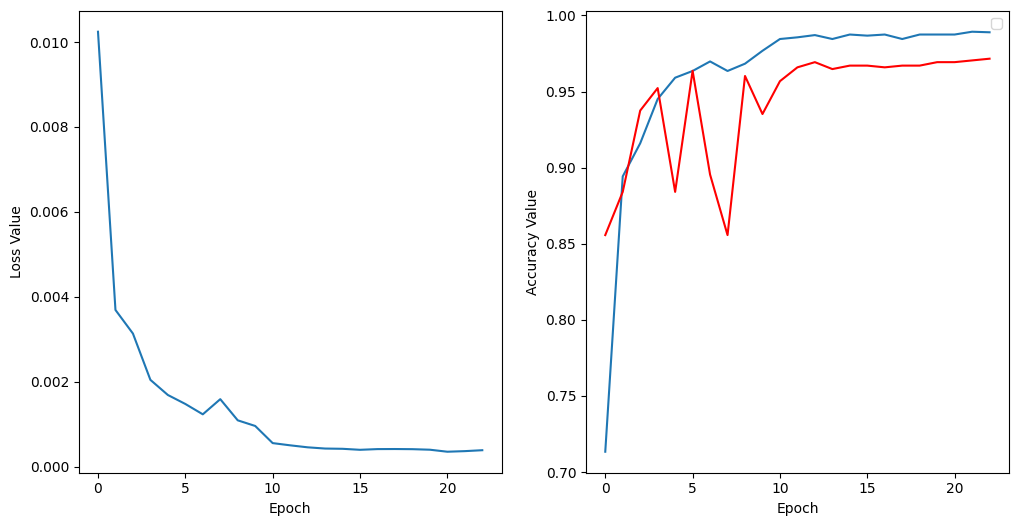

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(loss_saved)
plt.ylabel('Loss Value')
plt.xlabel('Epoch')


plt.subplot(1, 2, 2)
plt.plot(accuracy_saved)
plt.plot(test_accuracy_saved, color='r')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.legend()

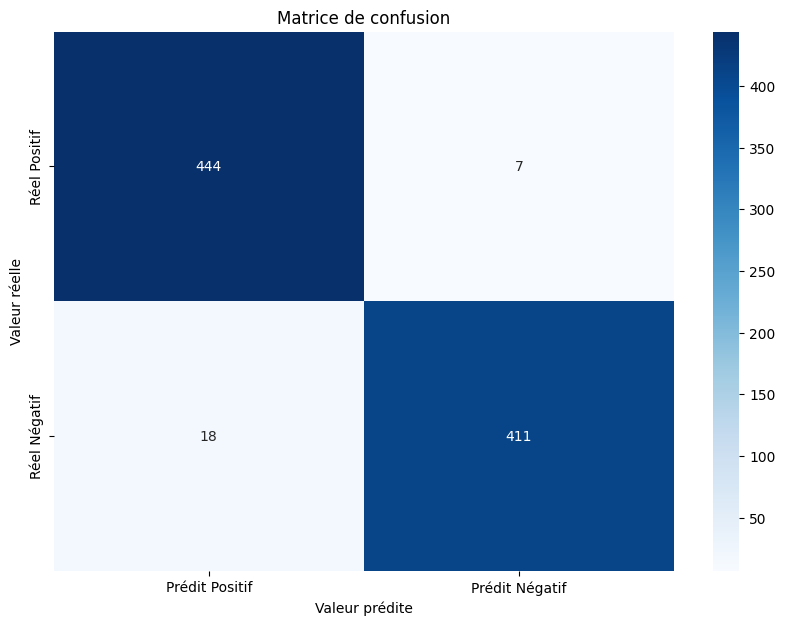

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Données de la matrice de confusion
conf_matrix = [[444, 7], [18, 411]]

# Conversion en DataFrame pour une meilleure visualisation avec Seaborn
df_cm = pd.DataFrame(conf_matrix, index=["Réel Positif", "Réel Négatif"], columns=["Prédit Positif", "Prédit Négatif"])

# Tracé de la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.ylabel("Valeur réelle")
plt.xlabel("Valeur prédite")
plt.show()


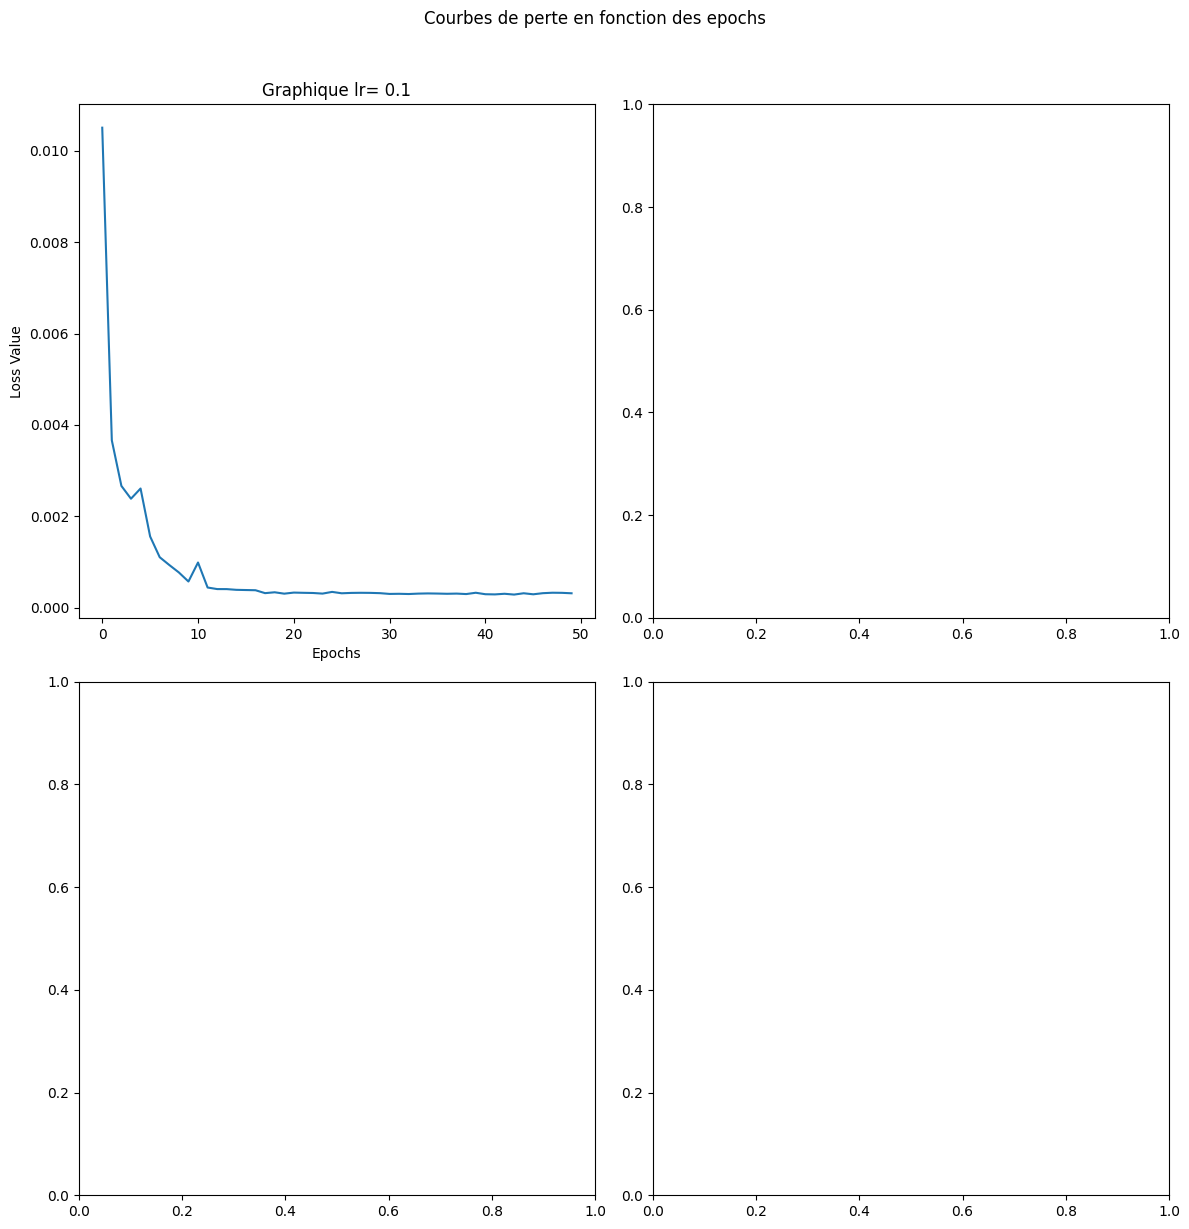

In [ ]:
import matplotlib.pyplot as plt

# Création d'une grille pour afficher les graphiques
fig, axes = plt.subplots(2, 2, figsize=(12, 6 * 2))
fig.suptitle('Courbes de perte en fonction des epochs', y=1.02)  # Titre global

# Affichage des courbes dans la grille
for i, loss_saved in enumerate(loss_saveds):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    ax.plot(loss_saved)


    # Ajout de titres aux axes pour chaque sous-plot
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss Value')
    ax.set_title(f'Graphique lr= {list_lr[i]}')

# Ajustement de l'espacement entre les sous-plots
plt.tight_layout()

# Affichage de la grille
plt.show()

### Print de l'accuracy en fonction des epochs

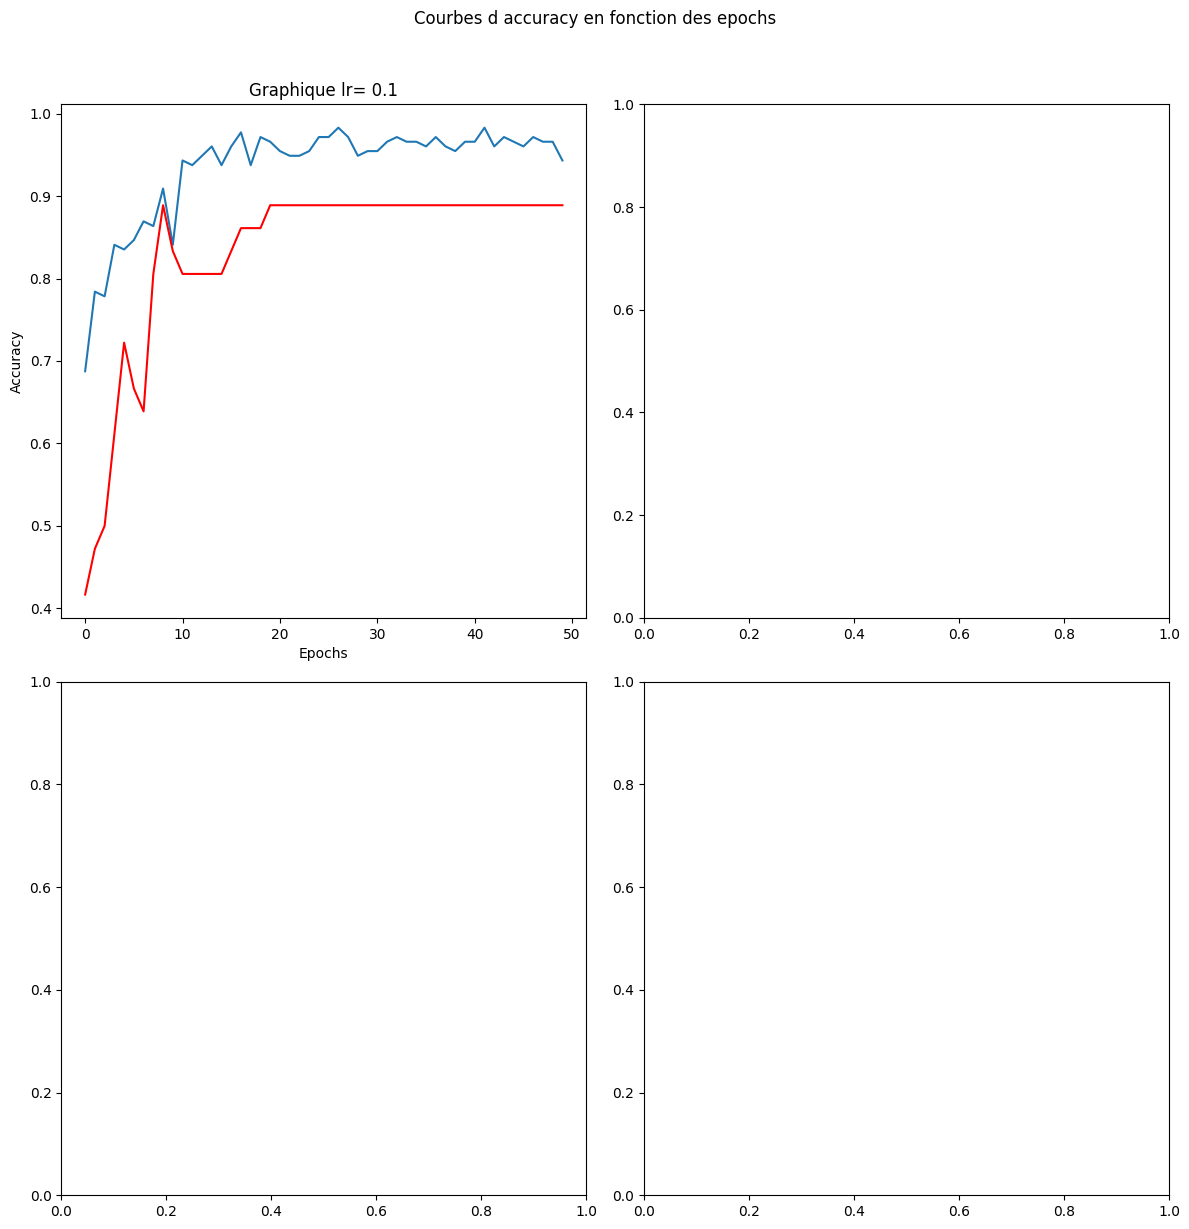

In [ ]:
# Création d'une grille pour afficher les graphiques
fig, axes = plt.subplots(2, 2, figsize=(12, 6 * 2))
fig.suptitle('Courbes d accuracy en fonction des epochs', y=1.02)  # Titre global

# Affichage des courbes dans la grille
for i, accuracy_saved in enumerate(accuracy_saveds):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    ax.plot(accuracy_saved,label='train')
    ax.plot(test_accuracy_saveds[i],color='r',label='test')

    # Ajout de titres aux axes pour chaque sous-plot
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Graphique lr= {list_lr[i]}')

# Ajustement de l'espacement entre les sous-plots
plt.tight_layout()

# Affichage de la grille
plt.show()

### Test the network on the test data

#### First test on one frame

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

img = images[0].cpu()  # Copie le tensor sur le CPU
label = labels[0].cpu()  # Copie le tensor sur le CPU

print(img.size())

plt.title(labels_map[int(label.numpy())])
plt.axis("off")
plt.imshow(denormalize(img))
plt.show

torch.Size([3, 576, 576])


NameError: name 'labels_map' is not defined

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

In [ ]:
predicted = predicted.cpu()  # Copie le tensor sur le CPU
print(labels_map[int(predicted[0].numpy())])


NameError: name 'labels_map' is not defined

#### Let us look at how the network performs on the whole dataset

#### Result by class

In [30]:
classes = ('vidmizer','autre')
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)  # Copie les images sur le GPU
        labels = labels.to(device)  # Copie les étiquettes sur le GPU
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: vidmizer is 34.2 %
Accuracy for class: autre is 68.2 %
